In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import sys
sys.setrecursionlimit(100000)
def rec_dd():
    return defaultdict(rec_dd)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator
from scipy import stats
plt.rcParams.update({
    "axes.titlesize": 26,    # Font size for axes titles
    "axes.labelsize": 25,    # Font size for axes labels
    "xtick.labelsize": 20,   # Font size for x-axis tick labels
    "ytick.labelsize": 20,   # Font size for y-axis tick labels
    "legend.fontsize": 26,   # Font size for legend
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})
from matplotlib.transforms import Bbox


# function

In [2]:
def plot_ax(data, ax, x_axis="resolution", y_axis="error", title="", legend=True, color="red", regplot=True, label="", x_pos=0.05, y_pos=0.95):
    ax.scatter(
        data[x_axis],
        data[y_axis],
        c=color,
        s=10,
        label=label,
    )
    r_value = stats.pearsonr(data[x_axis], data[y_axis]).statistic

    if regplot:
        # Compute the regression line manually
        slope, intercept, _, _, _ = stats.linregress(data[x_axis], data[y_axis])
        # Extend the regression line across the entire x-axis
        x_range = np.linspace(data[x_axis].min(), data[x_axis].max(), 500)
        y_range = slope * x_range + intercept

        ax.plot(
            x_range,
            y_range,
            color=color,
            linestyle="--",
            label=f"Regression Line {label}",
        )

    # Add the R-value as text on the plot
    ax.text(
        x_pos, y_pos,  # Position (adjust based on your plot)
        f"$r = {r_value:.2f}$",  # Format the R-value to 2 decimal places
        transform=ax.transAxes,  # Coordinate system for text placement
        fontsize=20,
        verticalalignment='top',
    )
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    if legend :
        ax.set_title(title)
        ax.legend()
        ax.legend(loc='upper right')
    return ax


# Read data

In [3]:
total_summary_epitope=pd.read_csv(
    "/home/gabrielathenes/Documents/all_structures/error_summary_250212_antigen.csv"
)
total_summary_paratope=pd.read_csv("/home/gabrielathenes/Documents/all_structures/error_summary_250212_antibody.csv")

data = pd.read_csv(
    "/home/gabrielathenes/Documents/all_structures/sabdab_summary_all.tsv",
    sep="\t",
)
print(len(data["pdb"].unique()))
data = data.query("resolution not in(['NOT','3.9, 3.9','8.9, 8.9'])")
data = data.astype({"resolution": float})
data = data.query(
    "antigen_type.isin(['peptide','protein'])"
)
print(len(data["pdb"].unique()))
data=data.dropna(subset=["Hchain", "Lchain"])
nanobodies = data[(data["Hchain"].str.contains(r'[a-z]') | data["Lchain"].str.contains(r'[a-z]'))]["pdb"].unique()
data=data.query("pdb not in @nanobodies")
print(len(data["pdb"].unique()))
data["group_size"] = data.groupby("pdb")["pdb"].transform('size')
data=data.query("group_size==2")
print(len(data["pdb"].unique()))

aacdb = pd.read_csv('/home/gabrielathenes/Documents/all_structures/antigen_antibody_data.csv')
duplicated_pdbs = aacdb.groupby("pdb").agg({"antibody": "nunique", "protein": "nunique"})
duplicated_pdbs = duplicated_pdbs[(duplicated_pdbs["antibody"] > 1) | (duplicated_pdbs["protein"] > 1)].index
result = aacdb[aacdb["pdb"].isin(duplicated_pdbs)]
pdbs = result["pdb"].str.lower().unique()

data=data.query("pdb not in @pdbs")
print(len(data["pdb"].unique()))


8697
5314
4051
1228
1122


In [4]:
for column in ['distance', 'error','error_normalized', 'epitope_size']:
    dict_to_use = total_summary_epitope.set_index("pdb")[column].to_dict()
    data[f"{column}_antigen"] = data["pdb"].map(dict_to_use)
total_summary_h = total_summary_paratope.query("chain=='Hchain'")
total_summary_l = total_summary_paratope.query("chain=='Lchain'")
for column in ['distance', 'error','error_normalized', 'paratope_size']:
    dict_to_use = total_summary_h.set_index("pdb")[column].to_dict()
    data[f"{column}_Hchain"] = data["pdb"].map(dict_to_use)
    dict_to_use = total_summary_l.set_index("pdb")[column].to_dict()
    data[f"{column}_Lchain"] = data["pdb"].map(dict_to_use)
data["paratope_size"]=data["paratope_size_Hchain"]+data["paratope_size_Lchain"]
data["distance_antibody"]=data["distance_Hchain"]+data["distance_Lchain"]
data["error_paratope"]=data["error_Hchain"]+data["error_Lchain"]


In [5]:
data_filtered=data.query("distance_Hchain<20 and distance_Lchain<20 and distance_antigen<40 and pdb!='8da0'")
data_filtered["normalized_error_epitope"]=data_filtered["error_antigen"]/data_filtered["epitope_size_antigen"]
data_filtered["normalized_error_paratope"]=data_filtered["error_paratope"]/data_filtered["paratope_size"]

data_filtered.to_csv("/home/gabrielathenes/Documents/all_structures/final_curated_data.csv")


/tmp/ipykernel_300485/1317865293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered["normalized_error_epitope"]=data_filtered["error_antigen"]/data_filtered["epitope_size_antigen"]
/tmp/ipykernel_300485/1317865293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered["normalized_error_paratope"]=data_filtered["error_paratope"]/data_filtered["paratope_size"]


/tmp/ipykernel_300485/19523546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered["total_paratope_size"] = data_filtered["paratope_size_Hchain"] + data_filtered["paratope_size_Lchain"]
/tmp/ipykernel_300485/19523546.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered["normalized_error"] = data_filtered["error_paratope"] / (data_filtered["total_paratope_size"] + 0.01)


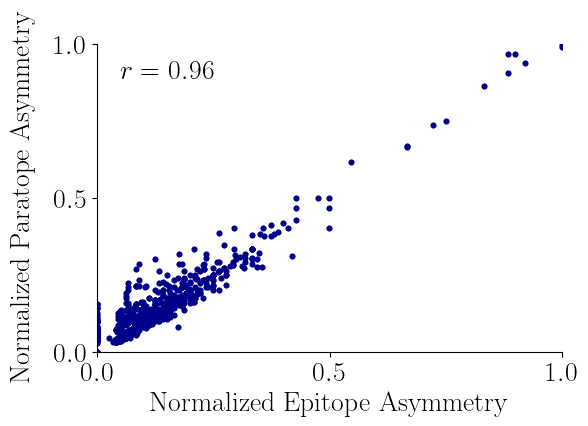

In [6]:
import matplotlib.pyplot as plt

# Assuming data_filtered and plot_ax are already defined
data_filtered["total_paratope_size"] = data_filtered["paratope_size_Hchain"] + data_filtered["paratope_size_Lchain"]
data_filtered["normalized_error"] = data_filtered["error_paratope"] / (data_filtered["total_paratope_size"] + 0.01)

fig, axes = plt.subplots(figsize=(6, 4))
ax = plot_ax(data_filtered,
             ax=axes,
             color="darkblue",
             x_axis="error_normalized_antigen",
             y_axis="normalized_error",
             regplot=False,
             legend=False,
             x_pos=0.05,
             y_pos=0.95)

# Remove top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

plt.ylabel(r"Normalized Paratope Asymmetry")
plt.xlabel(r"Normalized Epitope Asymmetry",fontsize=20)
plt.ylim([0, 1])
plt.xlim([0, 1])
# Remove default y-label
axes.set_ylabel("")
plt.xticks([0, 0.5, 1])
plt.yticks([0, 0.5, 1])
fig.text(-0.02, 0.5, r"Normalized Paratope Asymmetry", va='center', rotation='vertical', fontsize=20)
plt.show()
#plt.savefig("/home/gabrielathenes/Dropbox/paratyping/second_draft/figures/normalized_paratope_epitope_asymetry.png", bbox_inches='tight', dpi=300)
